In [1]:
gap_time = 1
#gap_time = 10  # gap time between each segment
win_size = [10, 30, 60]  # window size of each segment
step_max = 5 # maximum step of ConvLSTM


#raw_data_path = "output_file.csv"
raw_data_path = "month_finally_transposed_hourly_resampled.csv"  # path to load raw data
#model_path = '../MSCRED/'
train_data_path = ""
test_data_path = ""
reconstructed_data_path = ""


train_start_id = 10
train_end_id = 800

test_start_id = 800
test_end_id = 2000

valid_start_id = 800
valid_end_id = 1000

training_iters = 5
save_model_step = 1

learning_rate = 0.0002

threhold = 0.005
alpha = 1.5

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [3]:
class SignatureMatrices:
    def __init__(self):

        #df = pd.read_csv(raw_data_path)
        #df_new = df.drop(labels=0, axis=1)
        self.raw_data = pd.read_csv(raw_data_path, index_col = 0)
        self.series_number = self.raw_data.shape[0]
        self.series_length = self.raw_data.shape[1]
        self.signature_matrices_number = int(self.series_length / gap_time)

        print("series_number is", self.series_number)
        print("series_length is", self.series_length)
        print("signature_matrices_number is", self.signature_matrices_number)

    def signature_matrices_generation(self, win):
        """
        Generation signature matrices according win_size and gap_time, the size of raw_data is n * T, n is the number of
        time series, T is the length of time series.
        To represent the inter-correlations between different pairs of time series in a multivariate time series segment
        from t − w to t, we construct an n × n signature matrix Mt based upon the pairwise inner-product of two time series
        within this segment.
        :param win: the length of the time series segment
        :return: the signature matrices
        """

        if win == 0:
            print("The size of win cannot be 0")

        raw_data = np.asarray(self.raw_data)
        signature_matrices = np.zeros((self.signature_matrices_number, self.series_number, self.series_number))

        for t in range(win, self.signature_matrices_number):
            raw_data_t = raw_data[:, t - win:t]
            signature_matrices[t] = np.dot(raw_data_t, raw_data_t.T) / win
            #print("signature_matrices[t]: " + str(signature_matrices[t]))

        return signature_matrices

    def generate_train_test(self, signature_matrices):
        """
        Generate train and test dataset, and store them to ../data/train/train.npy and ../data/test/test.npy
        :param signature_matrices:
        :return:
        """
        train_dataset = []
        test_dataset = []

        for data_id in range(self.signature_matrices_number):
            index = data_id - step_max + 1
            if data_id < train_start_id:
                continue
            index_dataset = signature_matrices[:, index:index + step_max]
            if data_id < test_start_id:
                train_dataset.append(index_dataset)
            else:
                test_dataset.append(index_dataset)

        train_dataset = np.asarray(train_dataset)
        train_dataset = np.reshape(train_dataset, [-1, step_max, self.series_number, self.series_number,
                                                   signature_matrices.shape[0]])
        test_dataset = np.asarray(test_dataset)
        test_dataset = np.reshape(test_dataset, [-1, step_max,self.series_number, self.series_number,
                                                signature_matrices.shape[0]])

        print("train dataset shape is", train_dataset.shape)
        print("test dataset shape is", test_dataset.shape)

        train_path = ""
        #if not os.path.exists(train_path):
            #os.makedirs(train_path)
        train_path = "train.npy"

        test_path = ""
        #if not os.path.exists(test_path):
            #os.makedirs(test_path)
        test_path = "test.npy"

        np.save(train_path, train_dataset)
        np.save(test_path, test_dataset)


In [4]:
Matrices = SignatureMatrices()
signature_matrices = []

    # Generation signature matrices according the win size w
for w in win_size:
    signature_matrices.append(Matrices.signature_matrices_generation(w))
#print(signature_matrices)   

signature_matrices = np.asarray(signature_matrices)
print("the shape of signature_matrices is", signature_matrices.shape)

    # Generate train and test dataset
Matrices.generate_train_test(signature_matrices)


series_number is 4
series_length is 672
signature_matrices_number is 672
the shape of signature_matrices is (3, 672, 4, 4)
train dataset shape is (662, 5, 4, 4, 3)
test dataset shape is (0, 5, 4, 4, 3)


'\nfor i in range(4):\n    for j in range(3):\n        for k, matrix in enumerate(signature_matrices[0]):\n            row, col = k % 168, (j + 3*i)\n            ax = axes[row, col] \n            #sns.heatmap(matrix, ax=ax, cmap="YlGnBu", vmin=global_min, vmax=global_max, annot=False, cbar = False) \n'

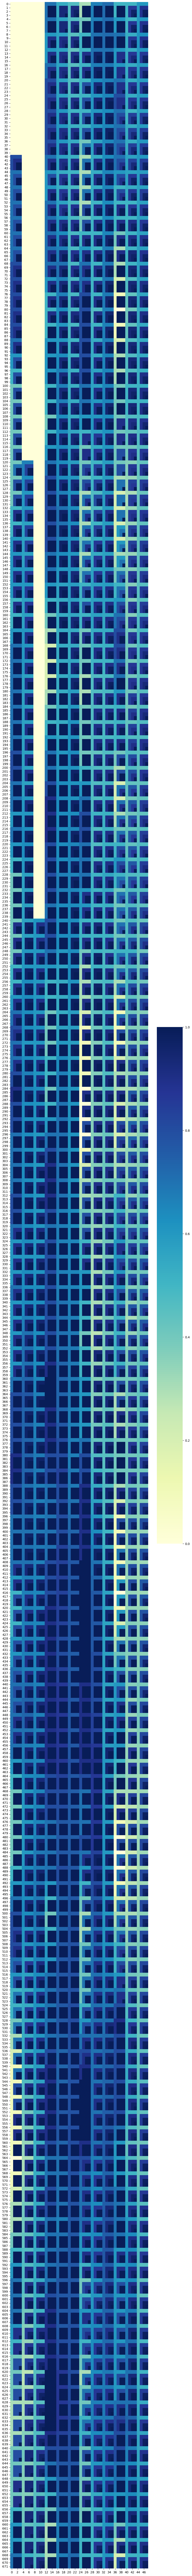

In [69]:
#fig, axes = plt.subplots(168, 12, figsize=(10, 150))
fig, axes = plt.subplots(1, 1, figsize=(10, 150))

global_min = np.min([np.min(matrix) for matrix in signature_matrices[0]])
global_max = np.max([np.max(matrix) for matrix in signature_matrices[0]])
new_big_matrix = np.zeros((4, 3, 672, 4))
for i in range(4):
    for j in range(3):
        idx1 = i * 168
        idx2 = (i + 1) * 168
        new_big_matrix[i][j] = np.concatenate(signature_matrices[j][idx1:idx2], axis = 0)
result = np.concatenate(np.concatenate(new_big_matrix, axis = 0), axis = 1)
sns.heatmap(result, cmap="YlGnBu", vmin=global_min, vmax=global_max, annot=False) 


**Max pooling visualization**

<AxesSubplot:>

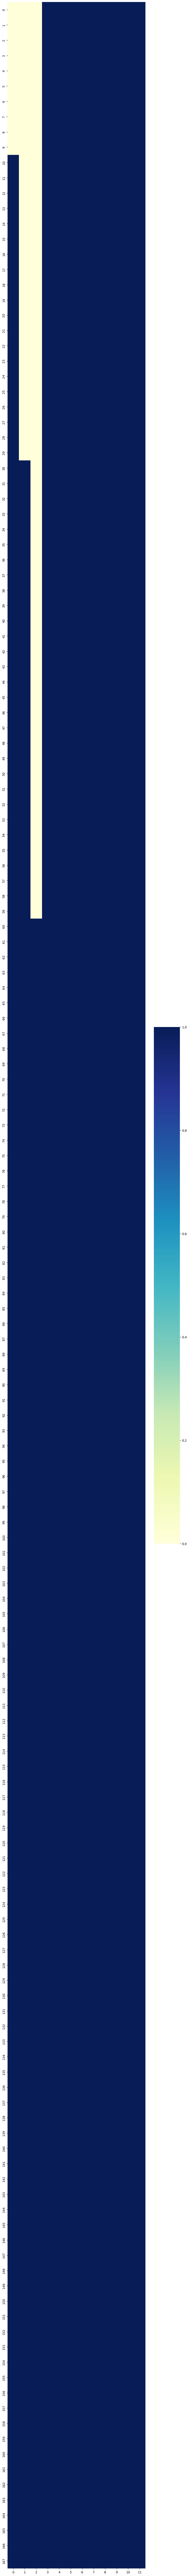

In [47]:
max_pooling_values = np.transpose(np.amax(signature_matrices, axis = (2, 3)))
split_arrays = np.split(max_pooling_values, indices_or_sections=4, axis=0)
concatenated_max_pooling_array = np.concatenate(split_arrays, axis=1)

fig, axes = plt.subplots(1, 1, figsize=(10, 150))
global_min = np.min([np.min(matrix) for matrix in signature_matrices[0]])
global_max = np.max([np.max(matrix) for matrix in signature_matrices[0]])
sns.heatmap(concatenated_max_pooling_array, cmap="YlGnBu", vmin=global_min, vmax=global_max, annot=False) 


**Min pooling visualization**

<AxesSubplot:>

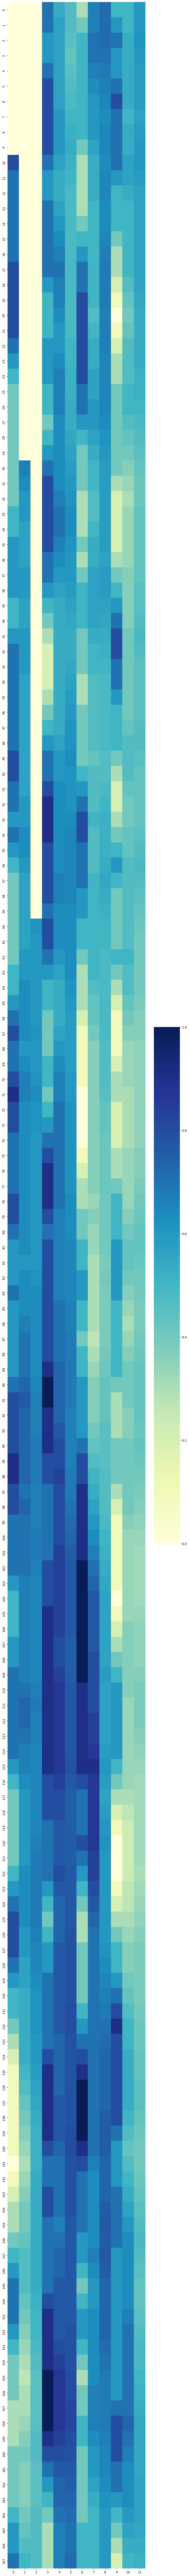

In [48]:
min_pooling_values = np.transpose(np.amin(signature_matrices, axis = (2, 3)))
min_split_arrays = np.split(min_pooling_values, indices_or_sections=4, axis=0)
concatenated_min_pooling_array = np.concatenate(min_split_arrays, axis=1)

fig, axes = plt.subplots(1, 1, figsize=(10, 150))
global_min = np.min([np.min(matrix) for matrix in signature_matrices[0]])
global_max = np.max([np.max(matrix) for matrix in signature_matrices[0]])
sns.heatmap(concatenated_min_pooling_array, cmap="YlGnBu", vmin=global_min, vmax=global_max, annot=False) 
